# Classification metrics

## 1. Implementing the model

In [29]:
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction import DictVectorizer

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.metrics import roc_auc_score, roc_curve
from IPython.display import display

In [4]:
df = pd.read_csv("churn.csv")

print("Number of examples: {}".format(len(df)))
df.T

Number of examples: 7043


,0,1,2,3,4,5,6,7,8,9,...,7033,7034,7035,7036,7037,7038,7039,7040,7041,7042
customerID,7590-VHVEG,5575-GNVDE,3668-QPYBK,7795-CFOCW,9237-HQITU,9305-CDSKC,1452-KIOVK,6713-OKOMC,7892-POOKP,6388-TABGU,...,9767-FFLEM,0639-TSIQW,8456-QDAVC,7750-EYXWZ,2569-WGERO,6840-RESVB,2234-XADUH,4801-JZAZL,8361-LTMKD,3186-AJIEK
gender,Female,Male,Male,Male,Female,Female,Male,Female,Female,Male,...,Male,Female,Male,Female,Female,Male,Female,Female,Male,Male
SeniorCitizen,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
Partner,Yes,No,No,No,No,No,No,No,Yes,No,...,No,No,No,No,No,Yes,Yes,Yes,Yes,No
Dependents,No,No,No,No,No,No,Yes,No,No,Yes,...,No,No,No,No,No,Yes,Yes,Yes,No,No
tenure,1,34,2,45,2,8,22,10,28,62,...,38,67,19,12,72,24,72,11,4,66
PhoneService,No,Yes,Yes,No,Yes,Yes,Yes,No,Yes,Yes,...,Yes,Yes,Yes,No,Yes,Yes,Yes,No,Yes,Yes
MultipleLines,No phone service,No,No,No phone service,No,Yes,Yes,No phone service,Yes,No,...,No,Yes,No,No phone service,No,Yes,Yes,No phone service,Yes,No
InternetService,DSL,DSL,DSL,DSL,Fiber optic,Fiber optic,Fiber optic,DSL,Fiber optic,DSL,...,Fiber optic,Fiber optic,Fiber optic,DSL,No,DSL,Fiber optic,DSL,Fiber optic,Fiber optic
OnlineSecurity,No,Yes,Yes,Yes,No,No,No,Yes,No,Yes,...,No,Yes,No,No,No internet service,Yes,No,Yes,No,Yes


In [5]:
df.SeniorCitizen = (df.SeniorCitizen == 1).astype(str)

df.columns = df.columns.str.lower().str.replace(" ", "_")

string_columns = list(df.dtypes[df.dtypes == "object"].index)

for col in string_columns:
    df[col] = df[col].str.lower().str.replace(" ", "_")
    
df.churn = (df.churn == "yes").astype(int)
    
df["totalcharges"] = pd.to_numeric(df["totalcharges"], errors = "coerce")
df["totalcharges"] = df["totalcharges"].fillna(0)

In [6]:
df_train_full, df_test = train_test_split(df, test_size = 0.2, random_state = 1)
df_train, df_val = train_test_split(df_train_full, test_size = 0.33, random_state = 2)

Y_train = df_train.churn.values
Y_val = df_val.churn.values
Y_test = df_test.churn.values

del df_train["churn"]
del df_val ["churn"]
del df_test["churn"]

### 1.1. Model with all features

In [7]:
numerical = list(df_train.dtypes[df_train.dtypes != "object"].index)
categorical = list(df_train.dtypes[df_train.dtypes == "object"].index)

del categorical[0]

print("Categorical variables: \n{}".format(categorical))
print("\nNumerical variables: \n{}".format(numerical))

Categorical variables: 
['gender', 'seniorcitizen', 'partner', 'dependents', 'phoneservice', 'multiplelines', 'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling', 'paymentmethod']

Numerical variables: 
['tenure', 'monthlycharges', 'totalcharges']


In [8]:
train_dict = df_train[categorical + numerical].to_dict(orient = "records")
val_dict = df_val[categorical + numerical].to_dict(orient = "records")
test_dict = df_test[categorical + numerical].to_dict(orient = "records")

dv = DictVectorizer(sparse = False)
dv.fit(train_dict)

X_train = dv.transform(train_dict)
X_val = dv.transform(val_dict)
X_test = dv.transform(test_dict)

In [9]:
model = LogisticRegression(solver = "liblinear", random_state = 1)
model.fit(X_train, Y_train)

Y_pred_val = model.predict_proba(X_val)[:, 1] 
Y_pred_test = model.predict_proba(X_test)[:, 1] 

churn_val = Y_pred_val > 0.5
churn_test = Y_pred_test > 0.5

### 1.2. Small model

In [10]:
subset = ['contract', 'tenure', 'totalcharges']

print("Features selected: {}".format(subset))

Features selected: ['contract', 'tenure', 'totalcharges']


In [11]:
train_dict_small = df_train[subset].to_dict(orient = "records")
val_dict_small = df_val[subset].to_dict(orient = "records")
test_dict_small = df_test[subset].to_dict(orient = "records")

dv = DictVectorizer(sparse = False)
dv.fit(train_dict_small)

X_train_small = dv.transform(train_dict_small)
X_val_small = dv.transform(val_dict_small)
X_test_small = dv.transform(test_dict_small)

In [12]:
model_small = LogisticRegression(solver = "liblinear", random_state = 2)
model.fit(X_train_small, Y_train)

Y_pred_val_small = model.predict_proba(X_val_small)[:, 1] 
Y_pred_test_small = model.predict_proba(X_test_small)[:, 1] 

churn_val_small = Y_pred_val_small > 0.5
churn_test_small = Y_pred_test_small > 0.5

## 2. Accuracy

### 2.2. Small model

In [23]:
acc_small = accuracy_score(y_true = Y_val, y_pred = churn_val_small)
print("Accuracy: {}".format(acc_small))

Accuracy: 0.7725806451612903


### 2.1. Model with all features

In [14]:
threshold = np.linspace(0, 1, 11)
accuracy = []

for t in threshold:
    acc = accuracy_score(y_true = Y_val, y_pred = Y_pred_val >= t)
    accuracy.append(acc)
    
print("Accuracy: {}".format(max(accuracy)))

Accuracy: 0.8193548387096774


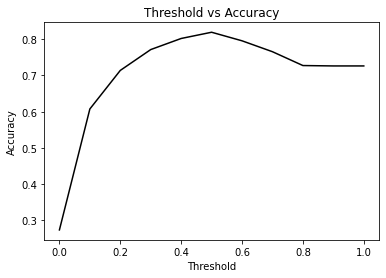

In [15]:
plt.figure(figsize = (6,4))

plt.plot(threshold, accuracy, color = "black", alpha = 1)

plt.xlabel("Threshold")
plt.ylabel("Accuracy")
plt.title("Threshold vs Accuracy")

plt.show()

### 2.3. Dummy model

In [16]:
size = len(Y_val)
Y_pred_dummy = np.repeat(False, size)

acc_dummy = accuracy_score(y_true = Y_val, y_pred = Y_pred_dummy)
print("Accuracy: {}".format(acc_dummy))

Accuracy: 0.7263440860215054


## 3. Confusion table

### 3.1. Model with all features

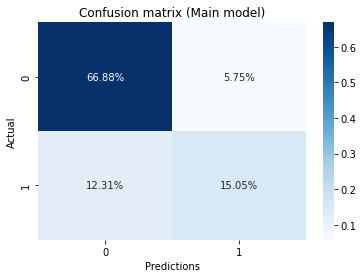

In [17]:
table = confusion_matrix(Y_val, churn_val)

plt.figure(figsize = (6,4))
sns.heatmap(table/table.sum(), annot = True, cmap = "Blues", fmt = ".2%")
plt.title("Confusion matrix (Main model)")
plt.xlabel("Predictions")
plt.ylabel("Actual")
plt.show()

### 3.2. Small model

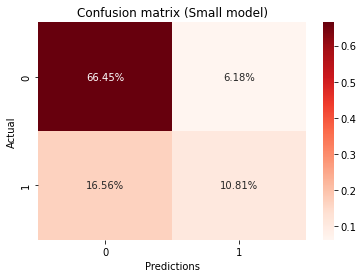

In [18]:
table_small = confusion_matrix(Y_val, churn_val_small)

plt.figure(figsize = (6,4))
sns.heatmap(table_small/table_small.sum(), annot = True, cmap = "Reds", fmt = ".2%")
plt.title("Confusion matrix (Small model)")
plt.xlabel("Predictions")
plt.ylabel("Actual")
plt.show()

## 4. Precision and Recall

### 4.1. Precision

The precision of a model tells us how many of the positive predictions turned out to be correct. It’s the fraction of correctly predicted positive examples.

Precision helps us understand how many people received a promotional message by mistake. The better the precision, the fewer false positives we have. The precision. of 72% means that 72% of the reached customers indeed were going to churn (our true positives), whereas the remaining 28% were not (false positives).

In [19]:
precision = precision_score(y_true = Y_val, y_pred = churn_val)
print("Precision (Main model): {}".format(precision))

precision_small = precision_score(y_true = Y_val, y_pred = churn_val_small)
print("Precision (Small model): {}".format(precision_small))

Precision (Main model): 0.7235142118863049
Precision (Small model): 0.6360759493670886


### 4.2. Recall

Recall is the fraction of correctly classified positive examples among all positive examples.

Recall helps us understand how many of the churning customers we failed to find.The better the recall, the fewer false negatives we have. The recall of 55% means that we reach only 55% of all churning users (true positives) and fail to identify the remaining 45% (false negatives)

In [20]:
recall = recall_score(y_true = Y_val, y_pred = churn_val)
print("Recall (Main model): {}".format(recall))

recall_small = recall_score(y_true = Y_val, y_pred = churn_val_small)
print("Recall (Small model): {}".format(recall_small))

Recall (Main model): 0.550098231827112
Recall (Small model): 0.3948919449901768


## 5. ROC and AUC

The ROC score represents how well the model can separate two classes: positive (churn) and negative (no churn). It is based on two quantities:
+ False positive rate (FPR): the fraction of false positives among all negative
examples. FPR is the fraction of users we predicted as churning among everybody who didn’t churn.
+ True positive rate (TPR): the fraction of true positives among all positive
examples. TPR is the fraction of users who we predicted as churning among everybody who actually did churn.

AUC (area under the curve) represents the probability that a randomly chosen positive example ranks higher than a randomly chosen negative example.

In [24]:
ROC = roc_auc_score(Y_val, Y_pred_val)
print("ROC: {}".format(ROC))

ROC: 0.8595372124846762


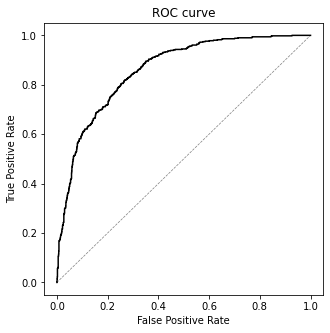

In [27]:
FPR, TPR, Thresholds = roc_curve(Y_val, Y_pred_val)

plt.figure(figsize = (5, 5))

plt.plot(FPR, TPR, color = "black")
plt.plot([0, 1], [0, 1], color = "black", linewidth  = 0.7, linestyle = "dashed", alpha = 0.5)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")

plt.show()

## K-fold cross validation


Previously, given the dataset, we splited it into train and validation test and these sets were used for only these purposes. This way, when we calculate an specific metric, it tells us how well the model will perform  on these specific dara points. It’s possible to use all the available data to assess the quality of models and get more reliable validation results: k-fold cross validation.

In [ ]:
kfold = KFold(n_splits = 10, shuffle = True, random_state = 1)

aucs = []

for train_index, val_index in kfold.split()